## Imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Import utility functions

In [3]:
# from helper_data import get_dataloaders_mnist
# from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
# from helper_plotting import plot_training_loss
# from helper_plotting import plot_generated_images
# from helper_plotting import plot_latent_space_with_labels
# from helper_plotting import plot_images_sampled_from_vae

In [4]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
BATCH_SIZE = 96
NUM_EPOCHS = 100

Device: cuda:0


In [5]:
set_deterministic
set_all_seeds(RANDOM_SEED)

https://www.kaggle.com/code/konradb/ts-6-deep-learning-for-ts-rnn-and-friends?scriptVersionId=108938187

## Dataset

In [6]:
df = pd.read_csv('datasets/selected_500user.csv')

# Data prepreration
# Get unique MeterID values
unique_meter_ids = df['MeterID'].unique()

# Create a new list of user IDs as strings
user_ids = [str(i) for i in range(len(unique_meter_ids))]

# Create a dictionary that maps each unique MeterID value to a unique user ID
user_id_dict = {meter_id: user_id for meter_id, user_id in zip(unique_meter_ids, user_ids)}

# Create a new column "user" that maps each MeterID value to a user ID
df["user"] = df["MeterID"].apply(lambda x: user_id_dict[x])

# Select user_1 to explore
user_1 = df[df['user']=='0']

# Drop not useful columns
user_1['DATE-Time'] = pd.to_datetime(user_1['DATE-Time'], infer_datetime_format=True)
user_1.drop(columns=["MeterID", "user"], inplace=True)

# Resample `15min` in order to have completed `"DATE-Time"`
# I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
# It should be (365day * 96point = 35040 rows)
# I have to reset index in order to hava 35040 rows
# Fill the missing value
user_1 = user_1.set_index('DATE-Time').resample("15T").mean().fillna(method="ffill")
del df

In [7]:
data = user_1.copy()
data

,KWH
DATE-Time,
2021-01-01 00:00:00,0.602
2021-01-01 00:15:00,0.589
2021-01-01 00:30:00,0.410
2021-01-01 00:45:00,0.495
2021-01-01 01:00:00,0.450
...,...
2021-12-31 22:45:00,0.405
2021-12-31 23:00:00,0.349
2021-12-31 23:15:00,0.305


In [8]:
print(f'Max value: ',data.max()[0])
print(f'Min value: ',data.min()[0])
print(f'Mean value: ',data.mean()[0])
print(f'STD value: ',data.std()[0])

Max value:  3.784
Min value:  0.0
Mean value:  0.5940806792237444
STD value:  0.2931843112322777


Historical User 1 energy consumption visualization:


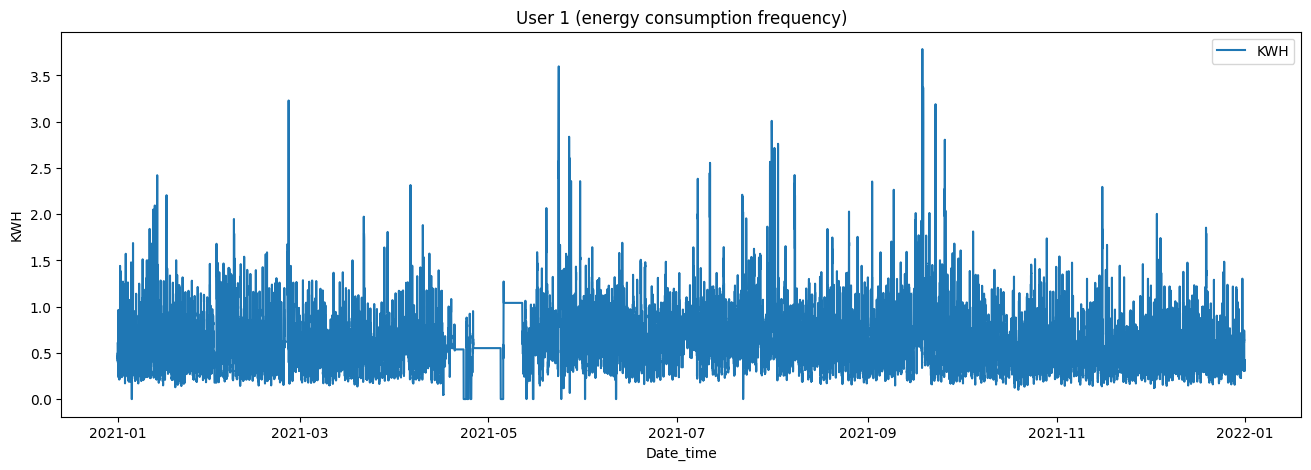

In [9]:
# Raw data visualization
print('Historical User 1 energy consumption visualization:')
plt.figure(figsize = (16,5))
plt.plot(data , label='KWH')
plt.title('User 1 (energy consumption frequency)')
plt.xlabel ('Date_time')
plt.ylabel ('KWH')
plt.legend();

In [10]:
# from adtk.visualization import plot
# plot(user_1, ts_linewidth=1, ts_markersize=5);

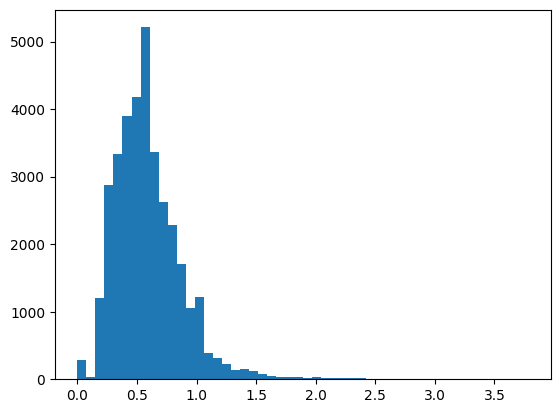

In [11]:
plt.hist(data, bins=50);

In [12]:
data.describe()

,KWH
count,35040.000000
mean,0.594081
std,0.293184
min,0.000000
25%,0.400000
50%,0.551000
75%,0.736000
max,3.784000


Box plot visualization:


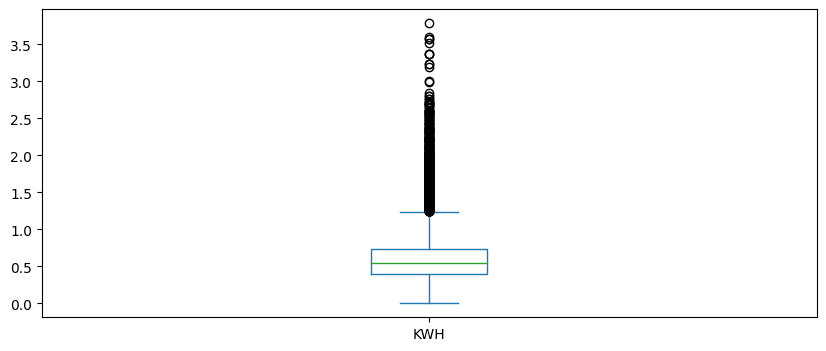

In [13]:
# Generate Boxplot
print('Box plot visualization:')
data.plot(kind='box', figsize = (10,4))
plt.show();

Histogram visualization:


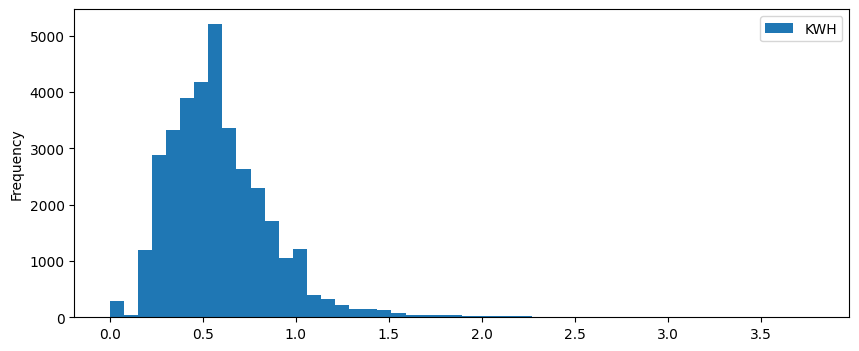

In [14]:
# Generate Histogram
print('Histogram visualization:')
data.plot(kind='hist', figsize = (10,4), bins=50)
plt.show();

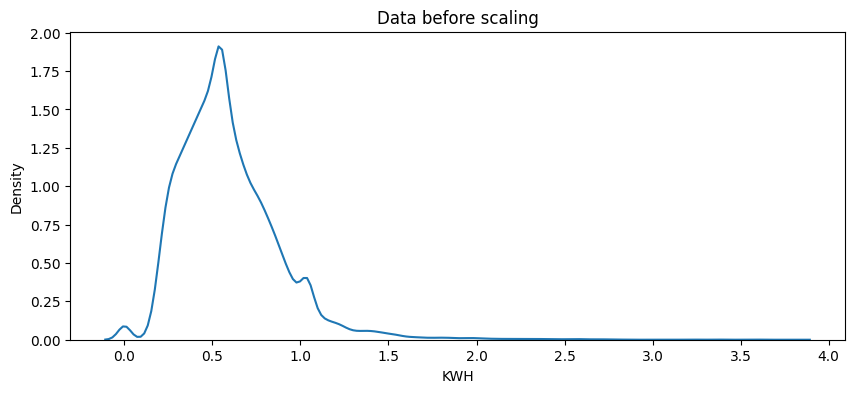

In [15]:
# Data before scaling
fig, ax1 = plt.subplots(ncols=1, figsize=(10,4))
ax1.set_title('Data before scaling')
sns.kdeplot(data['KWH'], ax=ax1)
plt.show();

## Load and preprocess the data

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [23]:
def create_dataset(df):
    sequences = df['KWH'].astype(np.float32).to_numpy().reshape(-1,1)
    dataset = [torch.tensor(s).float() for s in sequences]
    return dataset

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_normal_dataset = create_dataset(test_df)

print("Train dataset shape: ", len(train_dataset), train_dataset[0].shape)
print("Validation dataset shape: ", len(val_dataset), val_dataset[0].shape)
print("Test normal dataset shape: ", len(test_normal_dataset), test_normal_dataset[0].shape)

Train dataset shape:  22425 torch.Size([1])
Validation dataset shape:  5607 torch.Size([1])
Test normal dataset shape:  7008 torch.Size([1])


In [27]:
len(train_dataset)

22425

In [24]:
print("Train dataset shape: ", train_dataset.shape)
print("Validation dataset shape: ", val_dataset.shape)
print("Test normal dataset shape: ", test_normal_dataset.shape)

AttributeError: 'list' object has no attribute 'shape'

Shape of training: (21024, 1)
Shape of testing: (14016, 1)


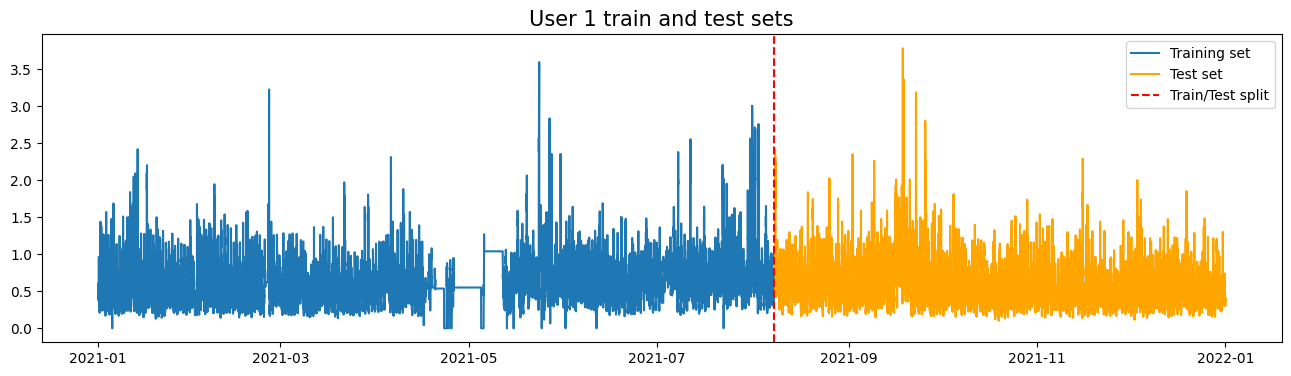

In [17]:
test_size = int(len(user_1) * 0.6)

df_train = data[:test_size]
df_test = data[test_size:]

print("Shape of training:", df_train.shape)
print("Shape of testing:", df_test.shape)

fig, ax = plt.subplots(figsize=(16,4))
ax.set_title('User 1 train and test sets', size=15)
ax.plot(df_train, label='Training set')
ax.plot(df_test, label='Test set', color='orange')
plt.axvline(x=df_test.index[0], linestyle='--', color='red', label='Train/Test split')
plt.legend();

In [18]:
df_train

,KWH
DATE-Time,
2021-01-01 00:00:00,0.602
2021-01-01 00:15:00,0.589
2021-01-01 00:30:00,0.410
2021-01-01 00:45:00,0.495
2021-01-01 01:00:00,0.450
...,...
2021-08-07 22:45:00,0.894
2021-08-07 23:00:00,0.889
2021-08-07 23:15:00,0.871


In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(df_train[['KWH']])

df_train['KWH'] = scaler.transform(df_train[['KWH']])
df_test['KWH'] = scaler.transform(df_test[['KWH']])

In [20]:
df_train.describe()

,KWH
count,21024.000000
mean,0.172224
std,0.085151
min,0.000000
25%,0.118085
50%,0.156519
75%,0.214901
max,1.000000


In [21]:
#As required for LSTM networks, we require to reshape an input data into `(n_samples x timesteps x n_features)`. 

seq_size = 96  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

After looping over all valid indices in x, the function returns two NumPy arrays: x_values and y_values. x_values has shape `(N, seq_size, M)` where N is the number of input/output pairs and M is the number of input features. y_values has shape `(N,)` and contains the corresponding output values for each input sequence. 

In [22]:
trainX, trainY = to_sequences(df_train, df_train, seq_size)
testX, testY = to_sequences(df_test, df_test, seq_size)

# check all shapes of train and test
print("trainX: ", trainX.shape)
print("testX: ", testX.shape)
print("\n")
print("trainY: ", trainY.shape)
print("testy: ", testY.shape)

trainX:  (20928, 96, 1)
testX:  (13920, 96, 1)


trainY:  (20928, 1)
testy:  (13920, 1)


In [23]:
# def create_dataset(df):
#     sequences = df.astype(np.float32).to_numpy().tolist()
#     dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
#     n_seq, seq_len, n_features = torch.stack(dataset).shape
#     return dataset, seq_len, n_features

In [24]:
# from sklearn.model_selection import train_test_split

# # Split normal examples into train, validation, and test sets
# train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=42)
# # val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=42)

# # Convert datasets to PyTorch format
# train_dataset, seq_len, n_features = create_dataset(train_df)
# val_dataset, _, _ = create_dataset(val_df)
# test_dataset, _, _ = create_dataset(test_df)

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.1))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

2023-03-29 09:10:32.351822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 09:10:32.415869: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-29 09:10:32.688115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-29 09:10:32.688149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 96, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 96, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 96, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 96, 1)            129       
 ibuted)                                                

Epoch 1/10


2023-03-29 09:12:15.686950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-03-29 09:12:15.825755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-29 09:12:15.826081: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xad341a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 09:12:15.826100: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-03-29 09:12:15.826103: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-03-29 09:12:15.828735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-29 09:12:15

589/589 [==============================] - 14s 18ms/step - loss: 0.0274 - val_loss: 0.0287
Epoch 2/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0235 - val_loss: 0.0319
Epoch 3/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0230 - val_loss: 0.0284
Epoch 4/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0227 - val_loss: 0.0280
Epoch 5/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0227 - val_loss: 0.0301
Epoch 6/10
589/589 [==============================] - 11s 18ms/step - loss: 0.0226 - val_loss: 0.0283
Epoch 7/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0224 - val_loss: 0.0276
Epoch 8/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0225 - val_loss: 0.0279
Epoch 9/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0224 - val_loss: 0.0279
Epoch 10/10
589/589 [==============================] - 10s 18ms/step - loss: 0.0223 - val_los

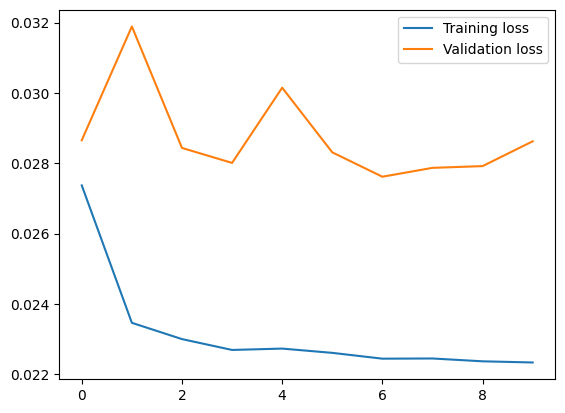

In [26]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [27]:
model.evaluate(testX, testY)

435/435 [==============================] - 4s 9ms/step - loss: 0.0236


0.02355247363448143

654/654 [==============================] - 4s 6ms/step


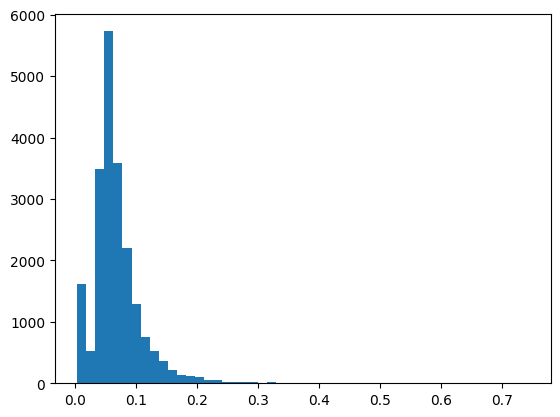

In [29]:
###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=50);

In [30]:
df_describe = pd.DataFrame(trainMAE)
df_describe.describe()

,0
count,20928.000000
mean,0.069481
std,0.044158
min,0.004310
25%,0.047558
50%,0.060705
75%,0.082642
max,0.743637


435/435 [==============================] - 3s 6ms/step


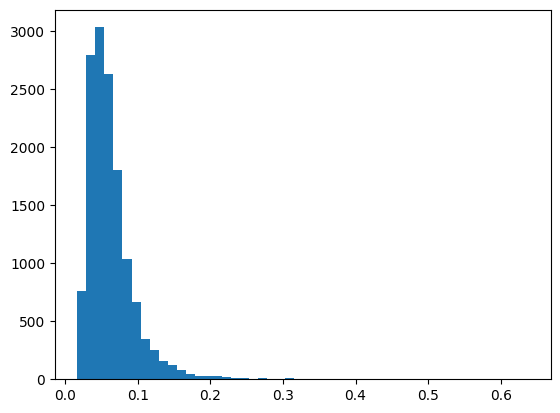

In [31]:
max_trainMAE = 0.162179  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=50);

In [32]:
df_test

,KWH
DATE-Time,
2021-08-08 00:00:00,0.217125
2021-08-08 00:15:00,0.257715
2021-08-08 00:30:00,0.247150
2021-08-08 00:45:00,0.244926
2021-08-08 01:00:00,0.264665
...,...
2021-12-31 22:45:00,0.112594
2021-12-31 23:00:00,0.097025
2021-12-31 23:15:00,0.084793


In [34]:
testMAE.shape

(13920, 1)

In [35]:
seq_size

96

In [36]:
max_trainMAE

0.162179

In [52]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(df_test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['KWH'] = df_test[seq_size:]['KWH']

In [53]:
len(anomaly_df[anomaly_df['anomaly']==True])

241

In [66]:
anomaly_df

,KWH,testMAE,max_trainMAE,anomaly
DATE-Time,,,,
2021-08-09 00:00:00,0.218515,0.083990,0.162179,False
2021-08-09 00:15:00,0.231860,0.087698,0.162179,False
2021-08-09 00:30:00,0.218515,0.084710,0.162179,False
2021-08-09 00:45:00,0.237420,0.087663,0.162179,False
2021-08-09 01:00:00,0.224354,0.083752,0.162179,False
...,...,...,...,...
2021-12-31 22:45:00,0.112594,0.024522,0.162179,False
2021-12-31 23:00:00,0.097025,0.022285,0.162179,False
2021-12-31 23:15:00,0.084793,0.028984,0.162179,False


In [57]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df.reset_index()['DATE-Time'], y=scaler.inverse_transform(anomaly_df.reset_index()['testMAE']))
sns.lineplot(x=anomaly_df.reset_index()['DATE-Time'], y=scaler.inverse_transform(anomaly_df.reset_index()['max_trainMAE']));

ValueError: Expected 2D array, got 1D array instead:
array=[0.08399043 0.0876978  0.08471025 ... 0.02898395 0.03830712 0.02412841].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [56]:
# Set the window size and batch size
window_size = 24 * 4 # 4 days of data
batch_size = 32

inputs = []
outputs = []
for i in range(len(data) - window_size):
    inputs.append(data['KWH_normalized'].iloc[i:i+window_size].values)  
    outputs.append(data['KWH_normalized'].iloc[i+window_size:i+window_size+1].values)  

# Convert the input/output pairs to PyTorch tensors and create data loaders
inputs = torch.tensor(inputs).unsqueeze(1).double() # add an extra dimension for the channel
outputs = torch.tensor(outputs).unsqueeze(1).double()
dataset = TensorDataset(inputs, outputs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Check shapes `(num_samples, window_size)` where num_samples is the number of input/output pairs we created and window_size is the size of the sliding window.
print('Input shape:', inputs.shape)     # (num_samples, 1, window_size, 1)
print('Output shape:', outputs.shape)   # (num_samples, 1, 1, 1)


Input shape: torch.Size([34944, 1, 96])
Output shape: torch.Size([34944, 1, 1])


### Here are the modifications you'll need to make:

* Modify the input layer to accept your time series data. You'll need to reshape your input data to be a 3D tensor of shape `(batch_size, num_channels, sequence_length)`, where `batch_size` is the number of samples in each batch, `num_channels` is the number of input features (in your case, `num_channels` should be 1 since you only have one feature), and `sequence_length` is the length of each input sequence (in your case, `sequence_length` should be the same as the `window_size` you defined earlier).

* Modify the output layer to generate the reconstructed time series data. You'll need to reshape the output tensor to have shape `(batch_size, sequence_length)`.

* Modify the loss function to take into account the time series nature of the data. One approach is to use the mean squared error (MSE) loss between the input and reconstructed output at each time step, and then sum up the losses across all time steps in each input sequence.

In [59]:
class TimeSeriesVAE(nn.Module):
    def __init__(self, input_size, hidden_size, bottleneck_size):
        super(TimeSeriesVAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bottleneck_size = bottleneck_size
        self.encConv1 = nn.Conv1d(1, hidden_size, kernel_size=3, padding=1)
        self.encConv2 = nn.Conv1d(hidden_size, hidden_size*2, kernel_size=3, padding=1)
        self.encFC1 = nn.Linear(hidden_size*2*input_size, bottleneck_size)
        self.encFC2 = nn.Linear(hidden_size*2*input_size, bottleneck_size)

        self.decFC1 = nn.Linear(bottleneck_size, hidden_size*2*input_size)
        self.decConv1 = nn.ConvTranspose1d(hidden_size*2, hidden_size, kernel_size=3, padding=1)
        self.decConv2 = nn.ConvTranspose1d(hidden_size, 1, kernel_size=3, padding=1)

    def encoder(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, self.num_flat_features(x))
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        x = self.decFC1(z)
        x = x.view(-1, self.hidden_size*2, self.input_size)
        x = F.relu(self.decConv1(x))
        x = self.decConv2(x)
        return x

    def forward(self, x):
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

    def loss_function(self, x, recon_x, mu, logVar):
        batch_size = x.size(0)
        mse_loss = F.mse_loss(recon_x, x, reduction='none')
        mse_loss = mse_loss.view(batch_size, -1).sum(dim=1)
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp(), dim=1)
        return mse_loss.mean() + kl_divergence.mean()

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [60]:
# Set hyperparameters
input_size = 96
hidden_size = 32
bottleneck_size = 16
learning_rate = 1e-3
num_epochs = 10

# Initialize the model, optimizer, and loss function
model = TimeSeriesVAE(input_size=window_size, hidden_size=hidden_size, bottleneck_size=bottleneck_size).double()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = model.loss_function

# Train the model for several epochs
num_epochs = 10
for epoch in range(num_epochs):
    for i, (input_seq, target_seq) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_seq, mu, logVar = model(input_seq)
        loss = loss_func(target_seq, recon_seq, mu, logVar)
        loss.backward()
        optimizer.step()

    # Print the loss every few epochs
    if epoch % 2 == 0:
        print(f"Epoch {epoch} loss: {loss.item():.4f}")

/tmp/ipykernel_12972/602809959.py:44: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(recon_x, x, reduction='none')


Epoch 0 loss: 0.7583
Epoch 2 loss: 0.5356
Epoch 4 loss: 0.5753
Epoch 6 loss: 0.3036
Epoch 8 loss: 0.4142


In [68]:
print(model.decFC1.weight.dtype)
print(model.decFC1.bias.dtype)
print(z.dtype)

torch.float64
torch.float64
torch.float32


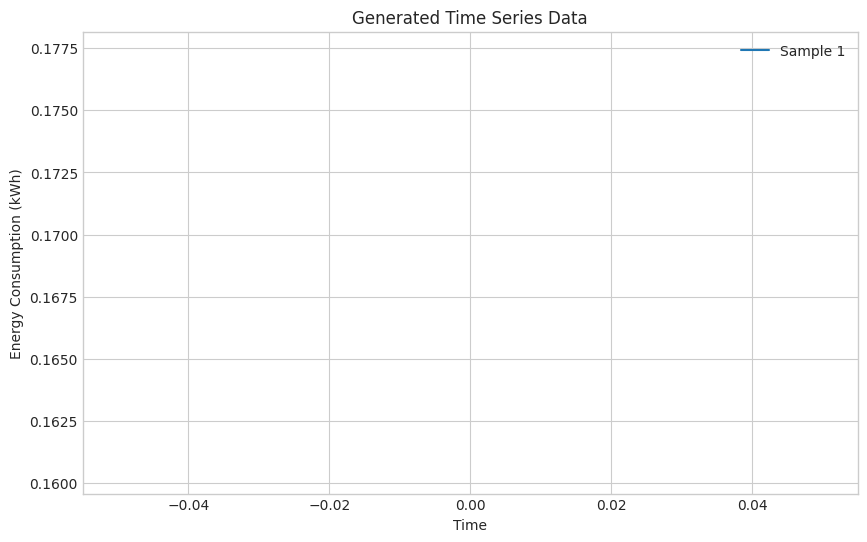

In [82]:
# Generate new time series data
num_samples = 1
with torch.no_grad():
    # Sample random points from the VAE's latent space
    z = torch.randn(num_samples, model.bottleneck_size).double()  # convert to torch.float64

    # Pass the points through the VAE's decoder to generate the corresponding time series
    generated_data = model.decoder(z).squeeze()

# Denormalize the generated data
generated_data = generated_data.to(torch.float32)
generated_data = generated_data * data['KWH_normalized'].std() + data['KWH_normalized'].mean()

# Plot the generated data
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.plot(generated_data[i].numpy(), label=f'Sample {i+1}')
plt.legend()
plt.title('Generated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

In [83]:
# Generate new time series data
num_samples = 1
with torch.no_grad():
    # Sample random points from the VAE's latent space
    z = torch.randn(num_samples, model.bottleneck_size).double()  # convert to torch.float64

    # Pass the points through the VAE's decoder to generate the corresponding time series
    generated_data = model.decoder(z).squeeze()

# Denormalize the generated data
generated_data = generated_data.to(data['KWH_normalized'].dtype==torch.float64)
generated_data = generated_data * data['KWH_normalized'].std() + data['KWH_normalized'].mean()

# Denormalize the original data
original_data = data['KWH_normalized'].to_numpy().reshape(-1, 96)[:num_samples] * data['KWH_normalized'].std() + data['KWH_normalized'].mean()

# Calculate the mean squared error between the generated data and the original data
mse = ((generated_data - original_data) ** 2).mean()

# Print the MSE
print(f'MSE: {mse:.4f}')

MSE: 0.0045


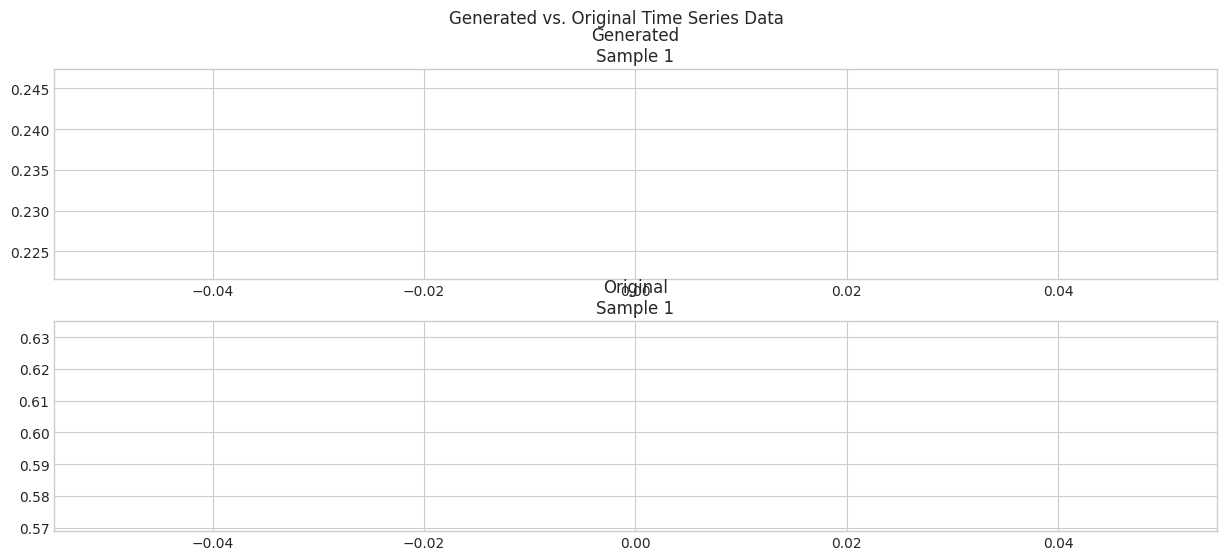

In [84]:
# Plot the generated and original data side by side
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples, i+1)
    plt.plot(generated_data[i].numpy())
    plt.title(f'Generated\nSample {i+1}')

    plt.subplot(2, num_samples, i+num_samples+1)
    plt.plot(data['KWH'][i])
    plt.title(f'Original\nSample {i+1}')

plt.suptitle('Generated vs. Original Time Series Data')
plt.show()

Shape of training: (21024, 1)
Shape of testing: (14016, 1)


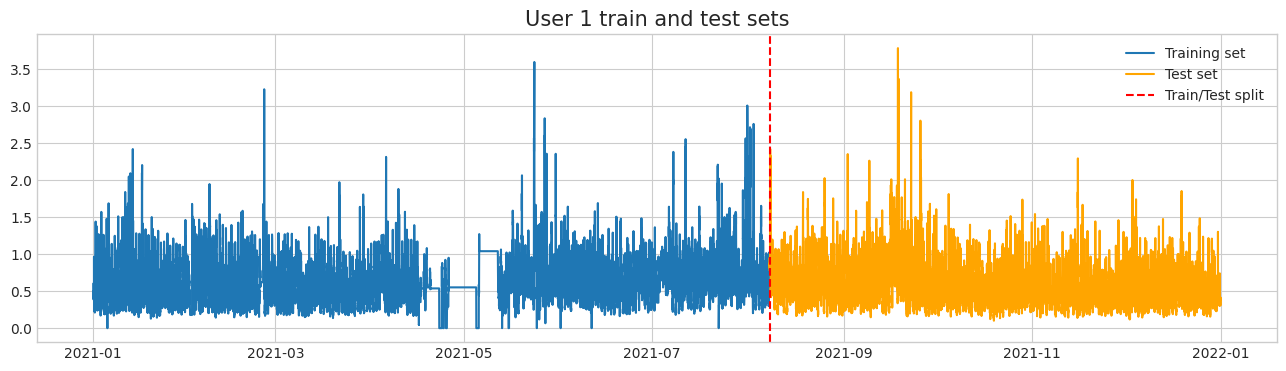

In [10]:
test_size = int(len(user_1) * 0.6)

df_train = user_1[:test_size]
df_test = user_1[test_size:]

print("Shape of training:", df_train.shape)
print("Shape of testing:", df_test.shape)

fig, ax = plt.subplots(figsize=(16,4))
ax.set_title('User 1 train and test sets', size=15)
ax.plot(df_train, label='Training set')
ax.plot(df_test, label='Test set', color='orange')
plt.axvline(x=df_test.index[0], linestyle='--', color='red', label='Train/Test split')
plt.legend();

In [14]:
# # separate train and validation
# # Mode 1
# from adtk.data import split_train_test
# splits = split_train_test(df_train, mode=1, n_splits=3, train_ratio=0.8)
# df = pd.DataFrame(index=df_train.index)
# for i, (train, val) in enumerate(splits):
#     df["train_{}".format(i)] = train
#     df["val_{}".format(i)] = val
# plot(df, 
#      curve_group=[("train_{}".format(i), "val_{}".format(i)) for i in range(3)],
#      ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"val_{}".format(i): "tab:orange" for i in range(3)}},
#      figsize=(16, 8));

In [13]:
# Cheak shape
df

,train_0,val_0,train_1,val_1,train_2,val_2
DATE-Time,,,,,,
2021-01-01 00:00:00,0.602,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:15:00,0.589,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:30:00,0.410,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:45:00,0.495,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,0.450,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-08-07 22:45:00,NaN,NaN,NaN,NaN,NaN,0.894
2021-08-07 23:00:00,NaN,NaN,NaN,NaN,NaN,0.889
2021-08-07 23:15:00,NaN,NaN,NaN,NaN,NaN,0.871


In [20]:
print(X.shape)
print(X.min())
print(X.max())

(21024, 1)
-2.022625063289615
9.721530108615754


Shape of training: (21024, 1)


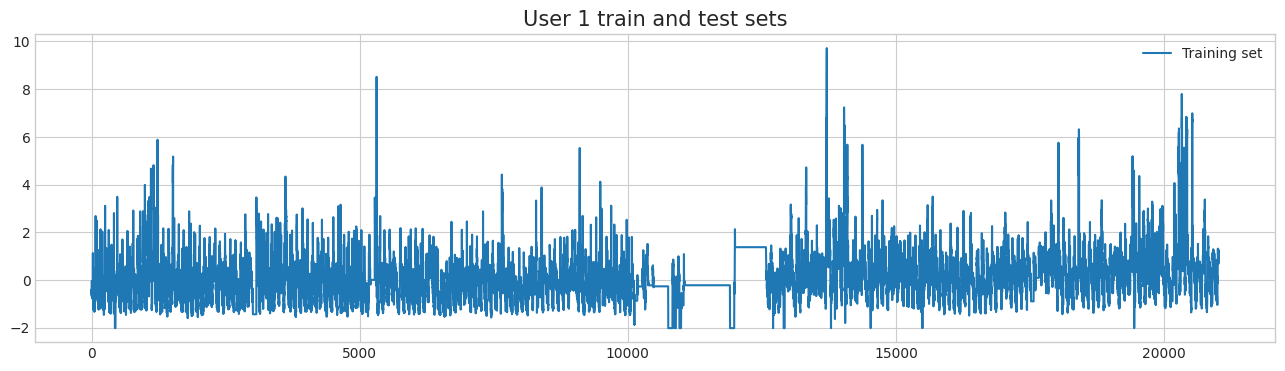

In [21]:
# test_size = int(len(user_1) * 0.6)

# df_train = user_1[:test_size]
# df_test = user_1[test_size:]

print("Shape of training:", X.shape)
# print("Shape of testing:", df_test.shape)

fig, ax = plt.subplots(figsize=(16,4))
ax.set_title('User 1 train and test sets', size=15)
ax.plot(X, label='Training set')
# ax.plot(df_test, label='Test set', color='orange')
# plt.axvline(x=df_test.index[0], linestyle='--', color='red', label='Train/Test split')
plt.legend();

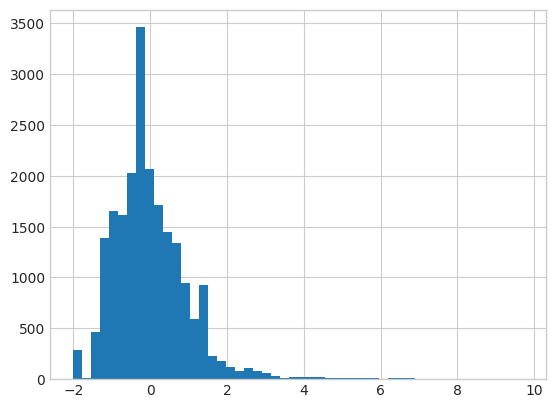

In [22]:
plt.hist(X, bins=50);

In [23]:
# Mode 1
from adtk.data import split_train_test
splits = split_train_test(X, mode=1, n_splits=3, train_ratio=0.8)
df = pd.DataFrame(index=X.index)
for i, (train, val) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["val_{}".format(i)] = val
plot(df, 
     curve_group=[("train_{}".format(i), "val_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"val_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

ValueError: Argument `ts` must be a pandas Series or DataFrame.

In [53]:
# Separate training and val sets
def separate_train_and_val_set(n_win):
        n_train = int(np.floor((n_win * 0.9)))   # returns an array of the same shape containing the floored values, it is `86`
        n_val = n_win - n_train   # 96 - 86 = 10
        idx_train = random.sample(range(n_win), n_train)
        idx_val = list(set(idx_train) ^ set(range(n_win)))   # returns a set that contains all the elements that are in either of the sets, but not in both
        return idx_train, idx_val, n_train, n_val

In [61]:
# Define the window size
window_size = 96

windowed_data = []
for i in range(0, len(df_train), window_size):
    window = user_1.iloc[i:i+window_size].values
    windowed_data.append(window)
    
# Convert the list of windows to a NumPy array
windowed_data = np.array(windowed_data)

# Split the data into training and validation sets
n_win = len(windowed_data)
idx_train, idx_val, n_train, n_val = separate_train_and_val_set(n_win)

# Select the appropriate windows for each set
train_data = [windowed_data[i] for i in idx_train]
val_data = [windowed_data[i] for i in idx_val]

# Normalize the training data
train_mean = np.mean(train_data)
train_std = np.std(train_data)
train_data = (train_data - train_mean) / train_std

# Normalize the validation data
val_data = (val_data - train_mean) / train_std

In [62]:
print(train_data.shape)
print(val_data.shape)

(197, 96, 1)
(22, 96, 1)


In [60]:
windowed_data.shape

(365, 96, 1)

In [14]:
# Split into training and test sets
train_size = int(len(user_1) * 0.6)
train_data = user_1[:train_size]
test_data = user_1[train_size:]

# Define window size
window_size = 96

# Split the training data into non-overlapping windows of size window_size
train_windows = []
for i in range(0, len(train_data), window_size):
    window = train_data.iloc[i:i+window_size].values
    train_windows.append(window)

# Randomly select 10% of the windows for validation
n_train_windows = len(train_windows)
n_val_windows = int(np.floor(n_train_windows * 0.1))
val_indices = random.sample(range(n_train_windows), n_val_windows)
train_indices = list(set(range(n_train_windows)) - set(val_indices))

# Select the appropriate windows for each set
train_windows_selected = [train_windows[i] for i in train_indices]
val_windows_selected = [train_windows[i] for i in val_indices]

# Convert the list of windows to a NumPy array
train_data = np.array(train_windows_selected)
val_data = np.array(val_windows_selected)

# Normalize the data
train_mean = np.mean(train_data)
train_std = np.std(train_data)
train_data_normalized = (train_data - train_mean) / train_std
val_data_normalized = (val_data - train_mean) / train_std

test_data_normalized = (test_data - train_mean) / train_std

# Define the PyTorch DataLoader objects
train_loader = DataLoader(dataset=train_data_normalized,
                          batch_size=32,
                          shuffle=True)

val_loader = DataLoader(dataset=val_data_normalized,
                        batch_size=32,
                        shuffle=True)

test_loader = DataLoader(dataset=test_data_normalized,
                         batch_size=32,
                         shuffle=False)

In [25]:
train_data.shape

(198, 96, 1)

In [17]:
for batch in train_loader:
    print(batch.shape)

torch.Size([32, 96, 1])
torch.Size([32, 96, 1])
torch.Size([32, 96, 1])
torch.Size([32, 96, 1])
torch.Size([32, 96, 1])
torch.Size([32, 96, 1])
torch.Size([6, 96, 1])


Shape of training: (21024, 1)
Shape of testing: (14016, 1)


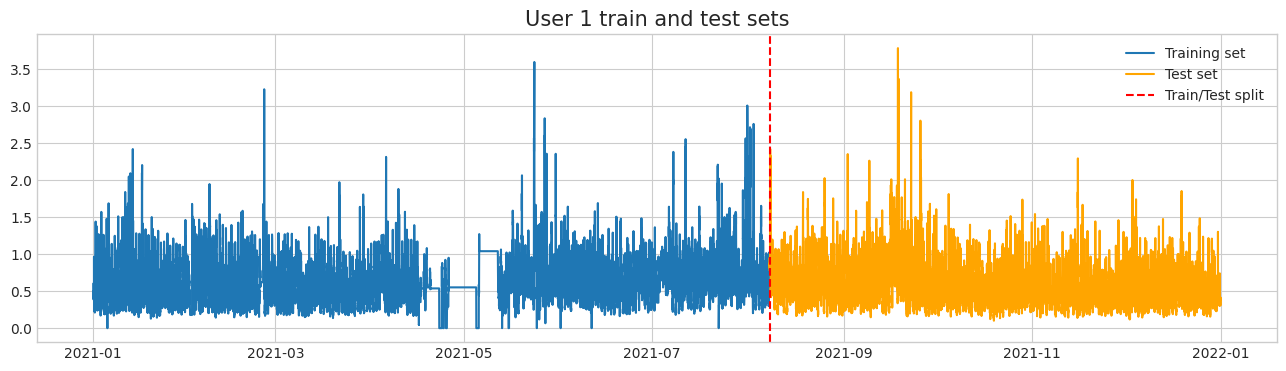

In [64]:
test_size = int(len(user_1) * 0.6)

df_train = user_1[:test_size]
df_test = user_1[test_size:]

print("Shape of training:", df_train.shape)
print("Shape of testing:", df_test.shape)

fig, ax = plt.subplots(figsize=(16,4))
ax.set_title('User 1 train and test sets', size=15)
ax.plot(df_train, label='Training set')
ax.plot(df_test, label='Test set', color='orange')
plt.axvline(x=df_test.index[0], linestyle='--', color='red', label='Train/Test split')
plt.legend();

In [75]:
# Separate training and val sets
def separate_train_and_val_set(n_win):
        n_train = int(np.floor((n_win * 0.9)))   # returns an array of the same shape containing the floored values, it is `86`
        n_val = n_win - n_train   # 96 - 86 = 10
        idx_train = random.sample(range(n_win), n_train)
        idx_val = list(set(idx_train) ^ set(range(n_win)))   # returns a set that contains all the elements that are in either of the sets, but not in both
        return idx_train, idx_val, n_train, n_val

In [78]:
# normalise by training mean and std 
train_m = np.mean(df_train)
train_std = np.std(df_train)
print("\nTraining set mean is {}".format(train_m[0]))
print("Training set std is {}".format(train_std[0]))
readings_normalised = (df_train - train_m) / train_std


Training set mean is 0.6194896308980213
Training set std is 0.3062800131085482


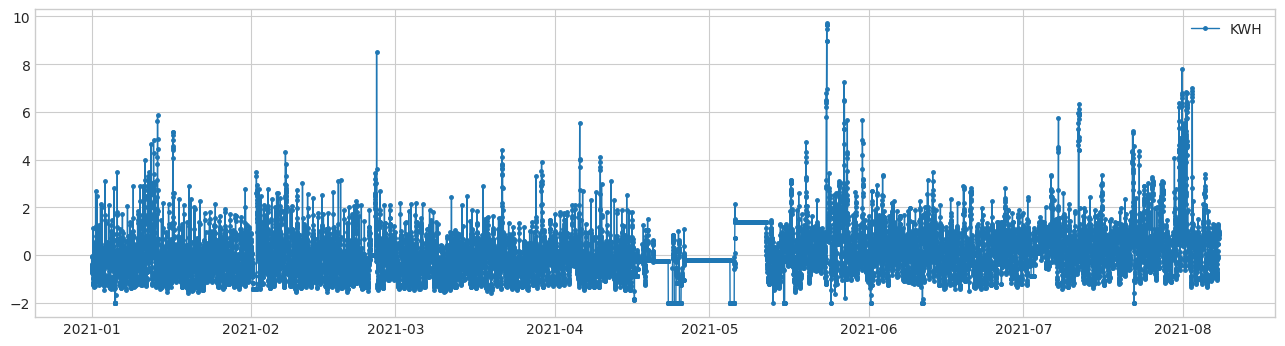

In [80]:
plot(readings_normalised, ts_linewidth=1, ts_markersize=5);

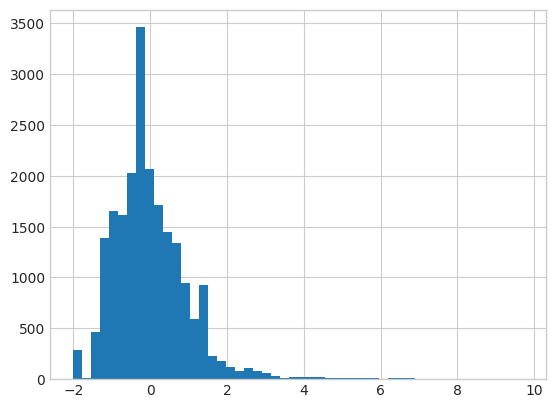

In [83]:
plt.hist(readings_normalised, bins=50);

## Model

## Training

## Evaluation